# Generate visualization based on output indicators 

In [1]:
import geopandas as gpd
import pandas as pd
import osmnx as ox
import numpy as np
import os
import setup_sp as sss
import time
from multiprocessing import Pool, cpu_count, Value, Manager, Process
from functools import partial
import json
import sys
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
#add basemap
#source: https://github.com/darribas/contextily; https://stackoverflow.com/questions/56559520/change-background-map-for-contextily
    
import contextily as ctx

def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))

In [3]:
# get the work directory
dirname = os.path.abspath('')

# the configuration file should put in the "/configuration" folder located at the same folder as scripts
jsonFile = "configuration/" + sys.argv[1]


In [4]:
# read json file
try:
    jsonPath = os.path.join(dirname, jsonFile)
    with open("configuration/cities.json") as json_file:
        config = json.load(json_file)
except Exception as e:
    print('Failed to read json file.')
    print(e)

folder = config['folder']
input_folder = config['input_folder']

# read city names from json
cities = list(config['cityNames'].values())
print("Cities:{}".format(cities))
# the path of "global_indicators_hex_250m.gpkg"
gpkgOutput_hex250 = os.path.join(dirname, folder,
                                 config['output_hex_250m'])

Cities:['adelaide', 'auckland', 'baltimore', 'bangkok', 'barcelona', 'belfast', 'bern', 'chennai', 'cologne', 'ghent', 'graz', 'hanoi', 'hong_kong', 'lisbon', 'melbourne', 'mexico_city', 'odense', 'olomouc', 'phoenix', 'sao_paulo', 'seattle', 'sydney', 'valencia', 'vic']


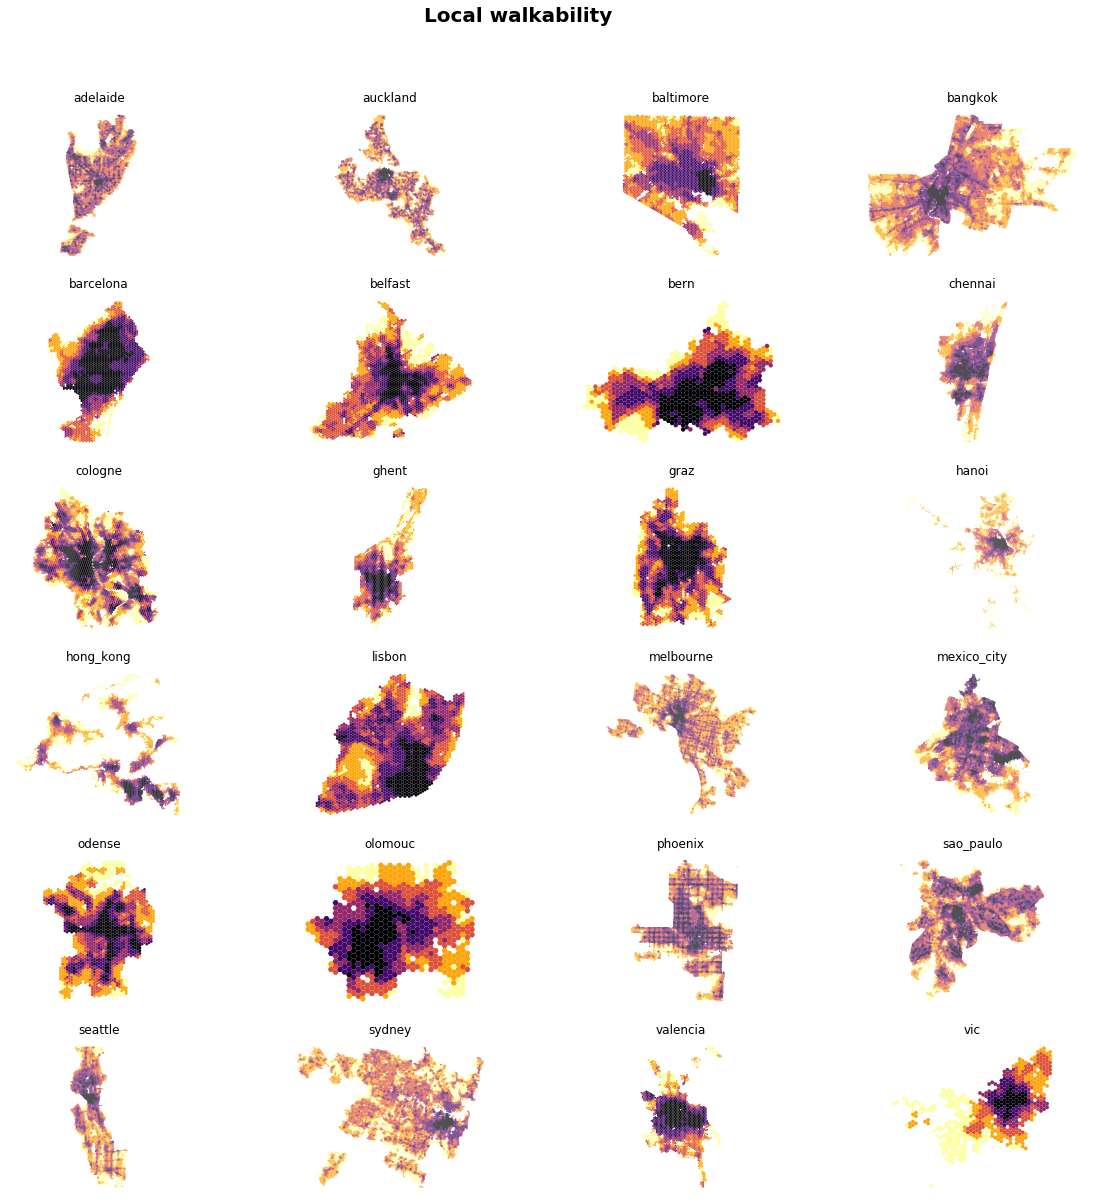

In [6]:
col=['all_cities_walkability']

fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(20, 20))

for ax, city in zip(axes.flatten(), cities):
    #read file
    hex250 = gpd.read_file(gpkgOutput_hex250, layer=config["cityNames"][city])
    
    #plot indicators
    ax = hex250.plot(ax=ax, column=col, scheme='NaturalBreaks', k=6, cmap='inferno_r', edgecolor='none')

    #add_basemap(ax, zoom=12, url=ctx.sources.ST_TONER_LITE)
    ax.set_title(config["cityNames"][city], fontsize=12)
    ax.set_axis_off()

# add a title to the figure
fig.suptitle('Local walkability', y=0.95, fontsize=20, weight='bold')

fig.savefig('maps/walkability.png', dpi=600)

plt.show()

In [7]:
# create the path of "global_indicators_city.gpkg"
gpkgOutput_cities = os.path.join(dirname, folder,
                                 config['global_indicators_city'])

cities_ind = gpd.GeoDataFrame()
for city in cities:
    #print(city)
    #read file
    city_ind = gpd.read_file(gpkgOutput_cities, layer=config["cityNames"][city])
    cities_ind = cities_ind.append(city_ind, ignore_index=True)

In [8]:
#correct vic study region column
cities_ind['Study region'] = cities_ind['Study region'].fillna('Vic')
cities_ind.columns

Index(['Study region', 'all_cities_pop_z_daily_living',
       'all_cities_walkability', 'area_sqkm', 'city', 'geometry',
       'pop_daily_living', 'pop_nh_intersection_density', 'pop_nh_pop_density',
       'pop_pct_access_500m_convenience', 'pop_pct_access_500m_pt_any',
       'pop_pct_access_500m_public_open_space',
       'pop_pct_access_500m_supermarkets', 'pop_walkability',
       'urban_sample_point_count'],
      dtype='object')

In [9]:
cities_ind[['Study region', 'all_cities_pop_z_daily_living', 'all_cities_walkability',
       'pop_daily_living', 'pop_nh_intersection_density', 'pop_nh_pop_density',
       'pop_pct_access_500m_convenience', 'pop_pct_access_500m_pt_any',
       'pop_pct_access_500m_public_open_space',
       'pop_pct_access_500m_supermarkets', 'pop_walkability', 'all_cities_pop_z_daily_living',
       'all_cities_walkability', 'urban_sample_point_count']].to_csv('maps/all_globe_cities_ind.csv')

In [11]:
# show pop-weighted walkability score ranking relative to all cities
cities_ind[['Study region', 'all_cities_walkability']].sort_values('all_cities_walkability').reset_index().drop(columns=['index'])

,Study region,all_cities_walkability
0,Melbourne,-0.434353
1,Sydney,-0.423386
2,Phoenix,-0.398935
3,Adelaide,-0.248834
4,Auckland,-0.044330
5,Ghent,-0.000461
6,Vic,0.091805
7,Bangkok,0.718315
8,Seattle,0.764752
9,Olomouc,0.908674
